In [1]:
import numpy as np
import random
import scipy.optimize as opt
import scipy.interpolate as intpl
import matplotlib.pyplot as plt
import pdb
import time
import sys
from numba import jit
sys.path.insert(0, "C:\\Users\\utabo\\Documents\\GitHub\\BootCamp2019\\ProblemSets\\ECON\\Week 5")
import parameters as p
import compileparam as compp

In [2]:
#Calculate transitions:
ee=0.9
eu=1-ee
uss=0.1
uu=(uss-(1-uss)*(eu))/uss
ue=1-uu
print(ue)
p.pi=np.array([[uu,ue],[eu,ee]])
print(p.pi)

0.8999999999999998
[[0.1 0.9]
 [0.1 0.9]]


In [3]:
def kss():
    k_ss = ((1/p.beta - 1 + p.delta)/p.alpha)**(1/(p.alpha-1))*(1-uss)
    return k_ss 
                                                                           
kinit=kss()      
print(kinit)

6.4900587533395635


In [4]:
def markovsim():
    eps=np.empty([p.numsim])
    eps[0]=0
    for x in range(p.numsim-1):
        ep=np.int_(eps[x])
        eps[x+1]= np.random.uniform(0,1) <= p.pi[ep,1]
    return eps
np.random.seed(386758)   
epsseries=markovsim()
print(np.mean(epsseries))
epsseries=np.int_(epsseries)


0.8998


In [5]:
def utility(x):
    if x>0:
        utils=np.log(x)
    else:
        utils=-(10**8)
    return utils

def negV(kprime,Vcont,eps,p,tt,r,w,kk) :
    V_t_interp0 = intpl.interp1d(p.kgrid,Vcont[:,0], kind='linear', fill_value='extrapolate') #bad
    V_t_interp1 = intpl.interp1d(p.kgrid,Vcont[:,1], kind='linear', fill_value='extrapolate')
    Vprime=np.empty([2])
    #Vprime[0,0]=np.interp(p.kgrid,Vcont[:,0], kprime) #good
    if tt>0:
        #pdb.set_trace()
        Vprime[0]=V_t_interp0(kprime) #bad
        Vprime[1]=V_t_interp1(kprime) #good
    else:
        Vprime=np.array([0][0])
    c=(1+r-p.delta)*kk+w*eps-kprime
    EV=np.sum(Vprime*p.pi[eps,:]) #expected value given transition probs
#     print(Vprime.shape)
#     print(p.pi.shape)
#     print(EV.shape)
    
    value=-1*(utility(c)+p.beta*EV) #negative value of choosing kprime
    return value
#Problem that the consumer solves given kbar:

def vfi(kbar,p,epsseries,u):
    Vcont=np.zeros([p.numptsk,2])
    pf=np.empty([p.numptsk, 2])
    vopt=np.empty([p.numptsk, 2])
    success=np.empty([p.numptsk, 2])
    r=p.alpha*kbar**(p.alpha-1)*(1-u)**(1-p.alpha)
    w=(1-p.alpha)*kbar**p.alpha*(1-u)**(-p.alpha)
    for tt in range(0,p.maxiter):
        for ixe, eps in enumerate(p.epsgrid):
            for ixk, kk in enumerate(p.kgrid):
                #res= opt.minimize_scalar(negV,bracket=(kk*0.00001,kk),args=(Vcont,eps,p,tt,r,w,kk), method='Golden' )          
                res= opt.minimize_scalar(negV,bounds=(kk*0.00001,kk*(1+r-p.delta)+w*eps),args=(Vcont,eps,p,tt,r,w,kk), method='bounded' )
                vopt[ixk,ixe] =-res.fun
                pf[ixk,ixe] =res.x
        diff=((vopt-Vcont) ** 2).sum()        
        if diff>p.tol:
            Vcont=vopt
        else:
            print("convergence 1 achieved")
            indk=np.empty(p.numsim)
            plt.show()
            #once we found a solution we want to simulate:
            #np.random.seed(56758)   
            #print(epsseries)
            #epsseries=markovsim()
            #epsseries=np.int_(epsseries)
            indk[0]=4
            kinterp= intpl.interp1d(p.kgrid,pf[:,0], kind='linear', fill_value='extrapolate')
            kinterp1= intpl.interp1d(p.kgrid,pf[:,1], kind='linear', fill_value='extrapolate')
            for ixN, epsilon in enumerate(epsseries[0:p.numsim-2]):
                #indk[ixN+1]=np.interp(indk[ixN],p.kgrid, pf[:,epsilon])
                indkcopy=indk[ixN]*(1+r-p.delta)+w*epsilon
                #indkcopy=indk[ixN]*(1+r-p.delta)
                if epsilon==1:
                    indk[ixN+1]=kinterp1(indkcopy)  
                else:
                    indk[ixN+1]=kinterp(indkcopy)  
                #print(indk[ixN+1])
                #indk[ixN]=intpl.interp1d(indk[ixN-1],p.kgrid, pf[:,epsilon], kind='cubic',fill_value='extrapolate')              
                #indk[ixN]=np.interp(p.kgrid, pf[:,epsilon],kss)
            kss=np.mean(indk[500:p.numsim-1])
            #kss=np.mean(indk)
            break
    return vopt, pf,kss,indk,success

def aiyagari(kbar,p,epsseries,u):
    for j in range(0,p.maxiter):
        print("outer loop:")
        print(j)
        vopt, pf,kss,indk,success=vfi(kbar,p,epsseries,u)
        if abs(kss-kbar)>p.tol_outer:            
            kbar=kss
            
        else:
            print("convergence 2 achieved")
            break
    return vopt, pf,kss,indk,success

In [6]:
start=time.clock()
vopt_out, pf_out,kss_out,indk,success=aiyagari(kinit,p,epsseries,uss)
end=time.clock()-start
print(end)

outer loop:
0


C:\Users\utabo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.


convergence 1 achieved
outer loop:
1
convergence 1 achieved
outer loop:
2
convergence 1 achieved
outer loop:
3
convergence 1 achieved
outer loop:
4
convergence 1 achieved
outer loop:
5
convergence 1 achieved
outer loop:
6
convergence 1 achieved
outer loop:
7
convergence 1 achieved
outer loop:
8
convergence 1 achieved
outer loop:
9
convergence 1 achieved
outer loop:
10
convergence 1 achieved
outer loop:
11
convergence 1 achieved
outer loop:
12
convergence 1 achieved
outer loop:
13
convergence 1 achieved
outer loop:
14
convergence 1 achieved
outer loop:
15
convergence 1 achieved
outer loop:
16
convergence 1 achieved
outer loop:
17
convergence 1 achieved
outer loop:
18
convergence 1 achieved
outer loop:
19
convergence 1 achieved
outer loop:
20
convergence 1 achieved
convergence 2 achieved
61.0501461


C:\Users\utabo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
print("steady state capial: ", kss_out)
print("interest rate: ", p.alpha*kss_out**(p.alpha-1)*(1-uss)**(1-p.alpha))
print("interest rate: ", p.alpha*kinit**(p.alpha-1)*(1-uss)**(1-p.alpha))
print("coefficient of variation of cap holdings: ", np.std(indk)/np.mean(indk))

steady state capial:  8.563873254270048
interest rate:  0.08513512125371339
interest rate:  0.10166666666666672
coefficient of variation of cap holdings:  0.3555419024559731


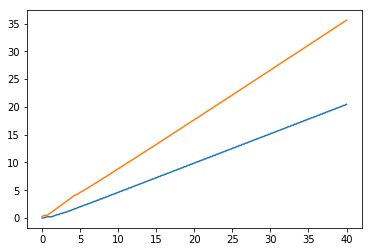

In [8]:
plt.plot(p.kgrid,pf_out[:,0])
plt.plot(p.kgrid,pf_out[:,1])
plt.show()

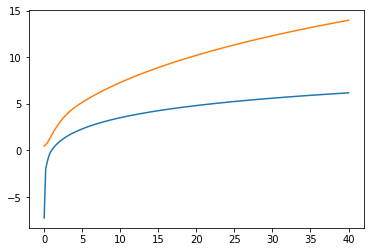

In [9]:
plt.plot(p.kgrid,vopt_out[:,0])
plt.plot(p.kgrid,vopt_out[:,1])
plt.show()